# Text-to-Speech using Tacotron2

Tacotron 2 is an advanced text-to-speech (TTS) system developed by Google that converts written text into natural-sounding speech. Combining deep learning techniques, Tacotron 2 leverages a sequence-to-sequence model with attention mechanisms to generate mel-spectrograms from text input. 

## Load Tacotron2Model

In [2]:
# Load the Tacotron2Model
from nemo.collections.tts.models import Tacotron2Model
from nemo.collections.tts.models.base import SpectrogramGenerator

# Let's see what pretrained models are available
print(Tacotron2Model.list_available_models())

ImportError: cannot import name 'ModelFilter' from 'huggingface_hub' (/home/levi/Speech-Course-Lab/env/lib/python3.11/site-packages/huggingface_hub/__init__.py)

In [2]:
# We can load the pre-trained model as follows
model = Tacotron2Model.from_pretrained("tts_en_tacotron2")

[NeMo I 2024-08-24 21:42:09 nemo_logging:381] Found existing object /home/levi/.cache/torch/NeMo/NeMo_1.23.0/tts_en_tacotron2/319a832e78fac50399d90aee0f083927/tts_en_tacotron2.nemo.
[NeMo I 2024-08-24 21:42:09 nemo_logging:381] Re-using file from: /home/levi/.cache/torch/NeMo/NeMo_1.23.0/tts_en_tacotron2/319a832e78fac50399d90aee0f083927/tts_en_tacotron2.nemo
[NeMo I 2024-08-24 21:42:09 nemo_logging:381] Instantiating model from pre-trained checkpoint


 NeMo-text-processing :: INFO     :: Creating ClassifyFst grammars.
[NeMo W 2024-08-24 21:42:29 nemo_logging:393] apply_to_oov_word=None, This means that some of words will remain unchanged if they are not handled by any of the rules in self.parse_one_word(). This may be intended if phonemes and chars are both valid inputs, otherwise, you may see unexpected deletions in your input.
[NeMo W 2024-08-24 21:42:29 nemo_logging:393] If you intend to do training or fine-tuning, please call the ModelPT.setup_training_data() method and provide a valid configuration file to setup the train data loader.
    Train config : 
    dataset:
      _target_: nemo.collections.tts.torch.data.TTSDataset
      manifest_filepath: /raid/datasets/tts_data/train_manifest.json
      sample_rate: 22050
      sup_data_path: null
      sup_data_types: null
      n_fft: 1024
      win_length: 1024
      hop_length: 256
      window: hann
      n_mels: 80
      lowfreq: 0
      highfreq: 8000
      max_duration: null

[NeMo I 2024-08-24 21:42:29 nemo_logging:381] PADDING: 16
[NeMo I 2024-08-24 21:42:29 nemo_logging:381] STFT using exact pad


[NeMo W 2024-08-24 21:42:29 nemo_logging:393] /home/levi/Speech-Course-Lab/env/lib/python3.11/site-packages/nemo/core/connectors/save_restore_connector.py:571: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related

[NeMo I 2024-08-24 21:42:29 nemo_logging:381] Model Tacotron2Model was successfully restored from /home/levi/.cache/torch/NeMo/NeMo_1.23.0/tts_en_tacotron2/319a832e78fac50399d90aee0f083927/tts_en_tacotron2.nemo.


## Tacotron2Model Text-to-Speech

[NeMo W 2024-08-24 21:42:52 nemo_logging:393] parse() is meant to be called in eval mode.


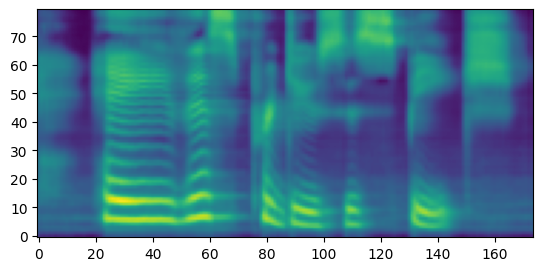

In [3]:
# Tacotron2 is a SpectrogramGenerator
assert isinstance(model, SpectrogramGenerator)

# SpectrogramGenerators in NeMo have two helper functions:
#   1. parse(self, text: str, normalize=True) which takes an English string and produces a token tensor
#   2. generate_spectrogram(self, *, tokens) which takes the token tensor and generates a spectrogram
# Let's try it out
tokens = model.parse(text = "Hey, this produces speech!")
spectrogram = model.generate_spectrogram(tokens = tokens)

# Now we can visualize the generated spectrogram
# If we want to generate speech, we have to use a vocoder in conjunction to a spectrogram generator.
# Refer to the TTS Inference notebook on how to convert spectrograms to speech.
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
%matplotlib inline
imshow(spectrogram.cpu().detach().numpy()[0,...], origin="lower")
plt.show()

## Training a Tacotron2Model

NeMo's training scripts are stored inside the examples/ folder. Let's grab the tacotron2.py file as well as the tacotron2.yaml file

In [ ]:
BRANCH = 'main'
!wget https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/examples/tts/tacotron2.py
!(mkdir -p conf \
  && cd conf \
  && wget https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/examples/tts/conf/tacotron2.yaml \
  && cd ..)

We will also need a few extra files for handling text.

In [ ]:
!(mkdir -p scripts/tts_dataset_files \
  && cd scripts/tts_dataset_files \
  && wget https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/scripts/tts_dataset_files/cmudict-0.7b_nv22.10 \
  && wget https://raw.githubusercontent.com/NVIDIA/NeMo/$BRANCH/scripts/tts_dataset_files/heteronyms-052722 \
  && cd ..)

After adjusting your configuration in `./conf/tacotron2.yaml`, you simply need to run `tacotron2.py` to start training your Tacotron 2 model. Here is the code inside `tacotron2.py`. You can run the following cell.

In [ ]:
import pytorch_lightning as pl

from nemo.collections.common.callbacks import LogEpochTimeCallback
from nemo.collections.tts.models import Tacotron2Model
from nemo.core.config import hydra_runner
from nemo.utils.exp_manager import exp_manager


# hydra_runner is a thin NeMo wrapper around Hydra
# It looks for a config named tacotron2.yaml inside the conf folder
# Hydra parses the yaml and returns it as a Omegaconf DictConfig
@hydra_runner(config_path="conf", config_name="tacotron2")
def main(cfg):
    # Define the Lightning trainer
    trainer = pl.Trainer(**cfg.trainer)
    # exp_manager is a NeMo construct that helps with logging and checkpointing
    exp_manager(trainer, cfg.get("exp_manager", None))
    # Define the Tacotron 2 model, this will construct the model as well as
    # define the training and validation dataloaders
    model = Tacotron2Model(cfg=cfg.model, trainer=trainer)
    # Let's add a few more callbacks
    lr_logger = pl.callbacks.LearningRateMonitor()
    epoch_time_logger = LogEpochTimeCallback()
    trainer.callbacks.extend([lr_logger, epoch_time_logger])
    # Call lightning trainer's fit() to train the model
    trainer.fit(model)

main()